In [89]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
import os
from torch.utils.data import  Dataset, DataLoader
from PIL import Image
import time 
import matplotlib.pyplot as plt
from collections import Counter
import gc
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import csv

from models import CNN_V1, CNN_V2, UNET_v3
from dataloader import CustomDataset

from torchviz import make_dot

In [90]:
train_path=r'F:\datasets\COVID_19_PPP_ZPO\Covid19-dataset\train'# scieżka do folderu z danymi treningowymi
test_path=r'F:\datasets\COVID_19_PPP_ZPO\Covid19-dataset\test'# scieżka do folderu z danymi testowymi
train=True
batch_size=32
epochs=20

model_select=1 # 1:CNN_V1 2: CNN_V2 3:UNET_V3 4:RESNET

In [91]:
label_to_class = {
    "Covid": 0,
    "Normal": 1,
    "Viral Pneumonia": 1
}

In [92]:
# resnet

resnet=models.resnet50(pretrained=True)
num_ftrs= resnet.fc.in_features
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.fc=nn.Linear(num_ftrs,3)


c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [93]:
gc.collect()
torch.cuda.empty_cache()

In [94]:
if torch.cuda.is_available:
    device="cuda"
    print("GPU available")
else:
    device="cpu"
    print("CPU only")
torch.cuda.empty_cache()

print("Dataset loading...")
set1=CustomDataset(train_path)
test_set=CustomDataset(test_path)
print("Dataset loaded succesfully!!!")
print("Model initialization...")
# model=UNET_v3(1,3)



# model.to(device)


GPU available
Dataset loading...
Loaded: 251 images 
class 0: 111 images 
class 1: 140 images 
Loaded: 66 images 
class 0: 26 images 
class 1: 40 images 
Dataset loaded succesfully!!!
Model initialization...


In [95]:
if model_select==1:
    model=CNN_V1().to(device)
    model.model_name=f"CNN_V1_epochs_{epochs}"

elif model_select==2:
    model=CNN_V2().to(device)
    model.model_name=f"CNN_V2_epochs_{epochs}"

elif model_select==3:
    model=UNET_v3(1,3).to(device)
    model.model_name=f"UNET_epochs_{epochs}"

elif model_select==4:
    model=resnet.to(device)
    model.model_name=f"RESNET_epochs_{epochs}"

print(model)

CNN_V1(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=359552, out_features=128, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (lin2): Linear(in_features=128, out_features=2, bias=True)
)


In [96]:
if train==False:
    path_to_model=r'UNET_epochs_150.pt'
    checkpoint=torch.load(path_to_model)
    model.load_state_dict(checkpoint)

epoch:0 loss:0.4457947015762329
epoch:1 loss:0.17426623404026031
epoch:2 loss:0.09288549423217773
epoch:3 loss:0.10394392907619476
epoch:4 loss:0.07398032397031784
epoch:5 loss:0.1383449137210846
epoch:6 loss:0.08170317858457565
epoch:7 loss:0.02061828039586544
epoch:8 loss:0.05295118689537048
epoch:9 loss:0.025868037715554237
epoch:10 loss:0.049045223742723465
epoch:11 loss:0.025632893666625023
epoch:12 loss:0.002274799160659313
epoch:13 loss:0.0009039037977345288
epoch:14 loss:0.006001200061291456
epoch:15 loss:0.00811399333178997
epoch:16 loss:0.03451237082481384
epoch:17 loss:0.006470858585089445
epoch:18 loss:0.005804095417261124
epoch:19 loss:0.0008927325252443552


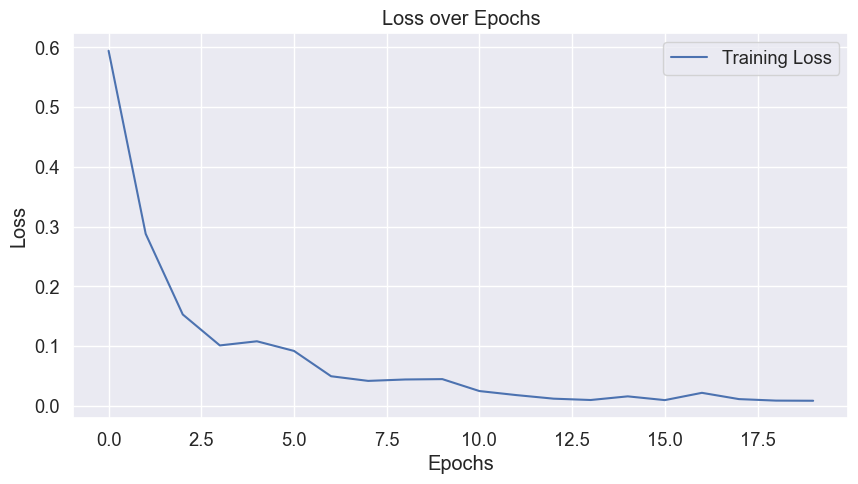

In [97]:
criterion=nn.CrossEntropyLoss().to(device)
optimizer=optim.Adam(model.parameters(), lr=0.0001)
loss_val=[]
data_loader=DataLoader(set1,batch_size=batch_size,shuffle=True)
if train:

    start_time=time.time()

    for epoch in range(epochs):
        loss_epoch=0.0
        for images,labels in data_loader:

            images=images.float()
            labels=labels.long()

            images=images.to(device)
            labels=labels.to(device)



            optimizer.zero_grad()
            out=model(images)

            loss=criterion(out,labels)
            loss.backward()
            optimizer.step()
            loss_epoch+=loss.item()*images.size(0)
        loss_epoch/=len(data_loader.dataset)
        loss_val.append(loss_epoch)
        print(f"epoch:{epoch} loss:{loss}")
            
    plt.figure(figsize=(10, 5))
    plt.plot(loss_val, label='Training Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [98]:
model.eval()
corr = 0
total = 0
predictions = []
true_labels = []

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.float()
        labels = labels.long()
        images = images.to(device)
        labels = labels.to(device)

        out = model(images)
        _, predicted = torch.max(out.data, 1)

        total += labels.size(0)
        corr += (predicted == labels).sum().item()

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

acc = (corr / total) * 100
print("Accuracy:", acc)

# Obliczanie macierzy pomyłek
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Inne miary jakości klasyfikacji
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 96.96969696969697
Confusion Matrix:
[[24  2]
 [ 0 40]]
Precision: 0.9711399711399712
Recall: 0.9696969696969697
F1 Score: 0.9694604582409461


In [99]:
# if train:
#     flat_coef_matrix = conf_matrix.flatten().tolist()

#     data_to_write = {
#         "Accuracy": acc,
#         "Precision": precision,
#         "Recall": recall,
#         "F1 Score": f1
#     }

#     # Dodanie wartości parametru loss
#     data_to_write["Loss Values"] = loss_val

#     data_to_write["Coefficient Matrix"] = flat_coef_matrix
#     csv_file = f"metrics_and_losses_{model.model_name}.csv"

#     with open(csv_file, mode='w', newline='') as file:
#         writer = csv.DictWriter(file, fieldnames=data_to_write.keys())
#         writer.writeheader()
#         writer.writerow(data_to_write)

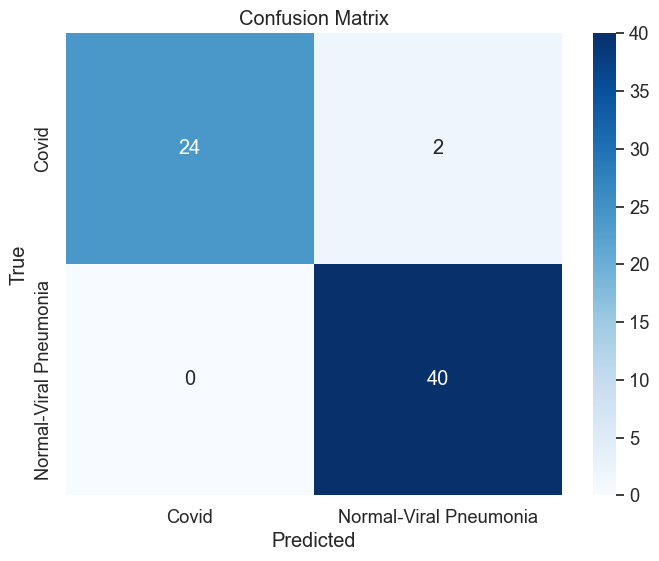

In [100]:
labels = ["Covid", "Normal-Viral Pneumonia"]

# Tworzenie wykresu heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# if train:  
#     plt.savefig(f'confusion_matrix_plot_{model.model_name}.png', bbox_inches='tight')  # Zapisuje jako plik PNG
plt.show()

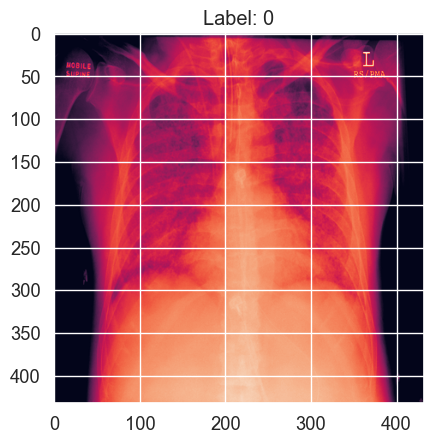

(432, 432)


In [101]:
index = 6 

# Wyświetl obraz
plt.imshow(set1.data[index])
plt.title(f"Label: {set1.labels[index]}")
plt.show()
print(set1.data[index].size)

In [102]:

if train:
    torch.save(model.state_dict(), f"{model.model_name}.pt")
    print(f"Model saved as {model.model_name}.pt")

Model saved as CNN_V1_epochs_20.pt
